In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (
    InputLayer, Conv2D, MaxPooling2D, Flatten,
    Dense, Reshape, Conv2DTranspose, Input
)
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import epsilon
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [5]:
from keras.layers import Input, Dense, Conv2D
import pickle

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd /content/drive/MyDrive/IIITB-FACES

/content/drive/MyDrive/IIITB-FACES
/content/drive/MyDrive/IIITB-FACES


In [8]:
data_dir="/content/drive/MyDrive/IIITB-FACES"

In [13]:
pip install keras-facenet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.8 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10369 sha256=bff5948551ff31b3a0b11d2bed51bedcfb7d28bd01473261c1fb9f523905680f
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [14]:
from keras_facenet import FaceNet
embedder = FaceNet()

In [40]:
# Define paths and parameters
dataset_directory = data_dir
image_size = (224, 224)  # Resize images to this size
num_classes = len(os.listdir(dataset_directory))  # Number of classes
print(num_classes)

# Initialize lists to store data
xtrain_embeddings = []
y_data = []
y_data_SVM=[]
labels = []

# Load and preprocess images and labels
for class_idx, class_name in enumerate(sorted(os.listdir(dataset_directory))):
    class_dir = os.path.join(dataset_directory, class_name)

    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)

        # Load and preprocess image
        detections = embedder.extract(image_path, threshold=0.95)
        embedding = detections[0].get('embedding')
        xtrain_embeddings.append(embedding)

        # target data
        y_data_SVM.append(class_name)

        # Create one-hot encoded label
        label = to_categorical(class_idx, num_classes=num_classes)
        y_data.append(label)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 44ms/step


In [41]:
print(len(xtrain_embeddings))
print(len(y_data_SVM))
print(len(y_data))

840
840
840


In [42]:
xtrain_embeddings=np.array(xtrain_embeddings)
print(xtrain_embeddings.shape)

(840, 512)


In [43]:
y_data = np.array(y_data)
y_data_SVM=np.array(y_data_SVM)

print(y_data.shape)
print(y_data_SVM.shape)

(840, 51)
(840,)


In [44]:
y_data = np.array(y_data)
y_data_SVM=np.array(y_data_SVM)
xtrain_embeddings=np.array(xtrain_embeddings)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    xtrain_embeddings, y_data, test_size=0.2, random_state=42, stratify=y_data
)

# Split data into train and test sets
x_train_SVM, x_test_SVM, y_train_SVM, y_test_SVM = train_test_split(
    xtrain_embeddings, y_data_SVM, test_size=0.2, random_state=42, stratify=y_data
)

In [45]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(x_train_SVM.shape)
print(x_test_SVM.shape)
print(y_train_SVM.shape)
print(y_test_SVM.shape)


(672, 512)
(168, 512)
(672, 51)
(168, 51)
(672, 512)
(168, 512)
(672,)
(168,)


# **ANN Classifier**

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras import regularizers
from keras.layers.core import Dropout

# Define the input layer
input_dim = 512  # Example: for 224x224x3 images
num_classes = y_train.shape[1]  # Number of classes

input_layer = Input(shape=(input_dim,))

# Define the hidden layers
hidden_layer_sizes = [256, 128, 64]

hidden_layer = input_layer
for layer_size in hidden_layer_sizes:
    hidden_layer = Dense(layer_size,activation='relu')(hidden_layer)

# Define the output layer for classification
output_layer = Dense(num_classes, activation='softmax')(hidden_layer)

# Create the classification model
classification_model = Model(inputs=input_layer, outputs=output_layer)

# Print a summary of the classification model
classification_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 51)                3315      
                                                                 
Total params: 175,795
Trainable params: 175,795
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compile the classifier
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
# Train the classifier using the encoded features and corresponding labels
classification_model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
21/21 [==============================] - 3s 4ms/step - loss: 3.8322 - accuracy: 0.2723
Epoch 2/10
21/21 [==============================] - 0s 3ms/step - loss: 3.2958 - accuracy: 0.3720
Epoch 3/10
21/21 [==============================] - 0s 3ms/step - loss: 2.1376 - accuracy: 0.6860
Epoch 4/10
21/21 [==============================] - 0s 3ms/step - loss: 0.8587 - accuracy: 0.9196
Epoch 5/10
21/21 [==============================] - 0s 3ms/step - loss: 0.2595 - accuracy: 0.9836
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 0.1007 - accuracy: 0.9985
Epoch 7/10
21/21 [==============================] - 0s 4ms/step - loss: 0.0493 - accuracy: 1.0000
Epoch 8/10
21/21 [==============================] - 0s 4ms/step - loss: 0.0304 - accuracy: 1.0000
Epoch 9/10
21/21 [==============================] - 0s 5ms/step - loss: 0.0215 - accuracy: 1.0000
Epoch 10/10
21/21 [==============================] - 0s 4ms/step - loss: 0.0162 - accuracy: 1.0000


In [52]:
pip install scikeras

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# evaluate model with standardized dataset
estimator = KerasClassifier(model=classification_model, epochs=20, batch_size=5, verbose=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, x_test, y_test, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 98.79% (2.42%)


# **SVM Classifier**

In [54]:
## Step 5: Initialize Classifer and fit training data
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param_grid = { 'C': [1e3, 5e3, 1e4, 5e4, 1e5],
               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(x_train, y_train_SVM)

print("Best Estimator found by Grid Search:")
print(clf.best_estimator_)

Best Estimator found by Grid Search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005)


In [55]:
from time import time
from sklearn.metrics import classification_report
## Step 6: Perform testing and get classification report
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(x_test)
#print(y_test)
#print(y_pred)
#for i in range(len(y_test)):
 # print(y_test[i], y_pred[i])

print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test_SVM, y_pred))

Predicting people's names on the test set
done in 0.057s
              precision    recall  f1-score   support

  IMT2012017       1.00      1.00      1.00         3
  IMT2012026       1.00      1.00      1.00         4
  IMT2012029       1.00      1.00      1.00         4
  IMT2012032       1.00      1.00      1.00         4
  IMT2012033       1.00      1.00      1.00         3
  IMT2012042       1.00      1.00      1.00         1
  IMT2012044       1.00      1.00      1.00         3
  IMT2013008       1.00      1.00      1.00         3
  IMT2013011       1.00      1.00      1.00         4
  IMT2013012       1.00      1.00      1.00         3
  IMT2013015       1.00      1.00      1.00         3
  IMT2013017       1.00      1.00      1.00         3
  IMT2013018       1.00      1.00      1.00         3
  IMT2013024       1.00      1.00      1.00         4
  IMT2013026       1.00      1.00      1.00         3
  IMT2013028       1.00      1.00      1.00         3
  IMT2013029       1.00 

# **Evaluation using webcam**

In [56]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [57]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [58]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [59]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to new_photo.jpg


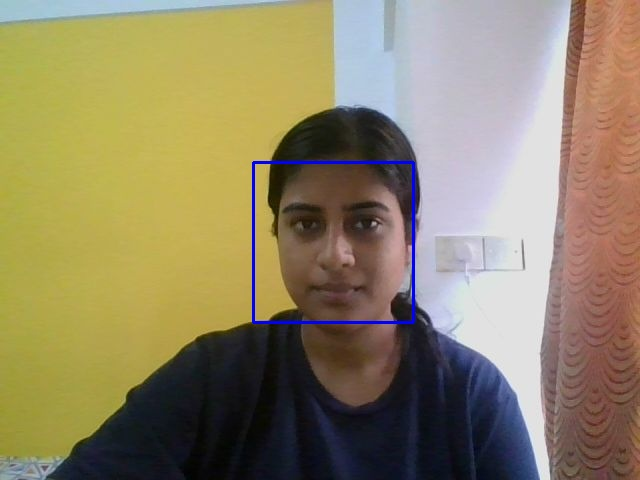

In [61]:
try:
  filename = take_photo('new_photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [62]:
%cd /content/drive/MyDrive/
z_data=[]
detections_test = embedder.extract("new_photo.jpg", threshold=0.95)
embedding_test = detections_test[0].get('embedding')


/content/drive/MyDrive
1/1 [==============================] - 0s 48ms/step


In [64]:
embedding_test.shape

(512,)

In [66]:
embedding_test=embedding_test.reshape(1, -1)
print('prediction from SVM')
pred = clf.predict(embedding_test)
print(pred)

prediction from SVM
['MS2022503']


In [68]:
print('prediction from ANN')
pred = classification_model.predict(embedding_test)
original_data = np.argmax(pred, axis=1)
print(original_data)

prediction from ANN
1/1 [==============================] - 0s 21ms/step
[34]
